In [401]:
import numpy as np
import random
from matplotlib import pyplot as plt

In [402]:
def show_maze(maze, path=None):  # shows maze
    if path is None:
        path = np.copy(maze)
        path.fill(False)

    path_masked = np.ma.masked_array(path, maze)
    maze_masked = np.ma.masked_array(maze, path)

    fig, ax = plt.subplots()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(path_masked, cmap='Reds', vmin=0, vmax=1)
    ax.imshow(maze_masked, cmap='binary', vmin=0, vmax=1)
    plt.show()

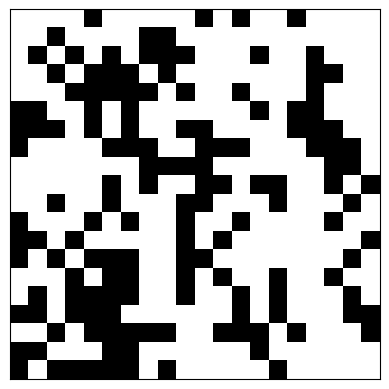

In [403]:
data = np.loadtxt("data/maze_3.csv", delimiter=",", dtype=bool)
n = len(data)
show_maze(data)

In [404]:
def get_incindence(maze):   # returns incindence matrix for connected graf, which contains (0, 0)
    n = len(maze)
    incidence = [np.array([False for i in range(n**2)])]
    end = len(maze) - 1
    reacheable = []
    previous_step_info = [((0, 0), (0, 0))]
    previous_step = [(0, 0)]
    steps = []

    while True:
        steps.append(previous_step_info)
        tmp_info = []
        tmp = []

        for point in previous_step:
            reacheable.append(point)
            where = [(-1, 0), (0, 1), (0, -1), (1, 0)]
            if point[0] == 0:
                where.remove((-1, 0))
            if point[1] == 0:
                where.remove((0, -1))
            if point[0] == end:
                where.remove((1, 0))
            if point[1] == end:
                where.remove((0, 1))

            for to in where:
                p = (point[0] + to[0], point[1] + to[1])

                if not maze[p[0], p[1]] and not (p in reacheable or p in previous_step or p in tmp):
                    tmp_info.append(tuple([point, p]))
                    tmp.append(p)

                    edge = [np.zeros(n**2, dtype=bool)]
                    edge[0][p[0] * n + p[1]] = True
                    edge[0][(point[0]) * n + point[1]] = True
                    incidence = np.append(incidence, edge, axis=0)

                if p == (end, end):
                    steps.append(tmp_info)
                                    
        if(len(tmp) == 0):
            incidence = np.delete(incidence, 0, axis=0)
            return incidence
        
        previous_step_info = tmp_info
        previous_step = tmp

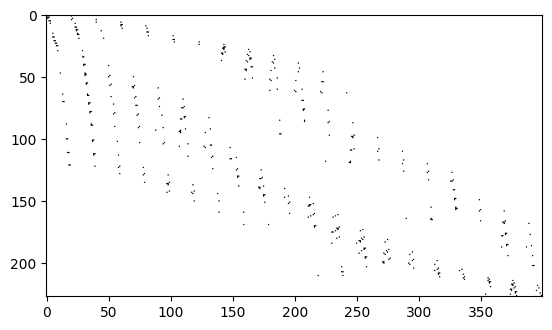

In [405]:
incidence = get_incindence(data)
fig, ax = plt.subplots()
ax.imshow(incidence, cmap='binary')
plt.show()

In [406]:
def dijkstra(incidence):
    nodes_inf = np.array([(-1, 0)], dtype=tuple)   # -1 - edge, 0 - node
    end = len(incidence[0]) - 1
    visited_nodes = np.array([0], dtype=int)   # nodes we've already been to
    edges = np.where(incidence[:, 0])[0]   # edges we're visiting this step
    while True:
        tmp_edges = np.array([], dtype=int)   # edges we'll visit in next step
        for edge in edges:
            nodes_tmp = np.where(incidence[edge])[0]   # nodes we can go to from this edge
            nodes_tmp = nodes_tmp[np.where(np.isin(nodes_tmp, visited_nodes) == False)[0]]   # nodes we can to from this edge, but without visited
            if(len(nodes_tmp)):
                nodes_inf = np.append(nodes_inf, [(edge, nodes_tmp[0])], axis=0)
            if end in nodes_tmp:
                return nodes_inf
            edges_tmp = np.where(incidence[:, nodes_tmp])[0]   # edges, leading to new nodes
            tmp_edges = np.append(tmp_edges, edges_tmp)
            visited_nodes = np.append(visited_nodes, nodes_tmp)
        edges = tmp_edges[:]

In [407]:
def get_path_dijkstra(dijkstra):
    n = int((dijkstra[-1, 1] + 1)**0.5)
    res = np.ndarray(shape=[n, n], dtype=bool)
    res.fill(False)
    res[0, 0] = True
    step = dijkstra[np.where(dijkstra[:, 1] == len(incidence[0]) - 1)][0]
    while step[0] != -1:
        node = step[1]
        x = node // n
        y = node % n
        res[x, y] = True
        nodes = np.where(incidence[step[0]])[0]   # current edge connects this nodes
        next_node = nodes[np.where(nodes != node)]   # we choose another node
        step = dijkstra[np.where(dijkstra[:, 1] == next_node)][0]
    return res

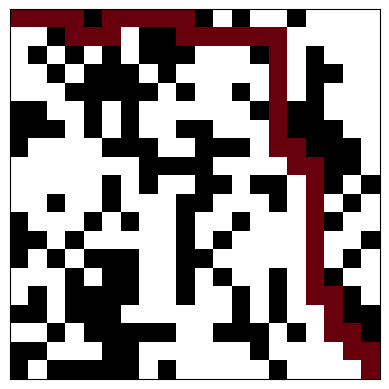

In [408]:
incidence = get_incindence(data)
d = dijkstra(incidence)
path = get_path_dijkstra(d)
show_maze(data, path)

In [409]:
def delete_wall(res, x, y):
    res[x, (y + 1) * 2 - 1] = False
    return res

In [410]:
def generate_maze(n, pattern='random', p=0.5):
    if pattern == 'random':
        tmp = []
        res = np.ndarray((n, n), dtype=bool)
        res.fill(False)
        for i in range(1, n, 2):
            if i != n - 1:
                res[:, i] = True
            res[i, :] = True
        res[0, :] = False
        res[-1, -1] = False
        r = 2
        walls = n // 2 - (n + 1) % 2
        while r < n:
            walls_d = np.where(np.random.randint(0, 2, walls, dtype=bool) == True)[0]
            tmp.append(walls_d)
            res[r, (walls_d + 1) * 2 - 1] = False
            r += 2
        
        for r in range(2, len(res), 2):
            s = 0
            while s < len(res):
                c = 0
                while s + c < len(res) and res[r, s + c] != True:
                    c += 1
                up = random.randint(0, c // 2)
                tmp = up * 2 + s
                d = tmp if tmp < n else tmp - 1
                res[r - 1, d] = False
                s += c + 1
    
        return res
    if pattern == 'slalom':
        c = (n // 2)
        res = np.ndarray((n, n), dtype=bool)
        res.fill(False)
        for i in range(1, n, 2):
            if random.random() <= p:
                l = random.randint(1, n - 1)
                if (i // 2) % 2 == 0:
                    res[:l, i] = True
                else:
                    res[-l:, i] = True
            res[-1, -1] = False
        return res
    if pattern == 'empty':
        res = np.ndarray((n, n), dtype=bool)
        res.fill(False)
        return res

Showcase:

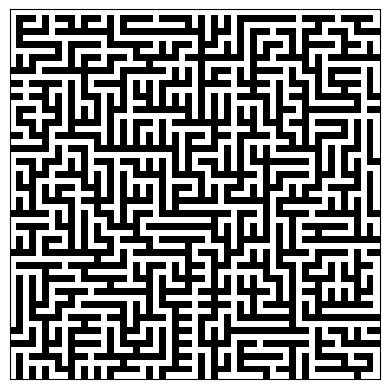

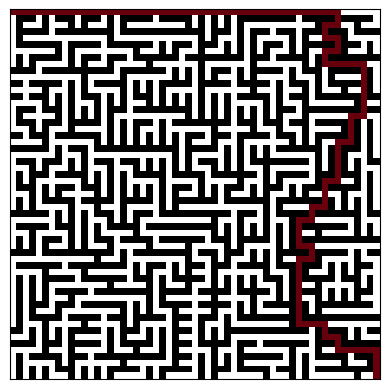

In [411]:
res = generate_maze(57, pattern='random')
show_maze(res)
incidence = get_incindence(res)
d = dijkstra(incidence)
path = get_path_dijkstra(d)
show_maze(res, path)

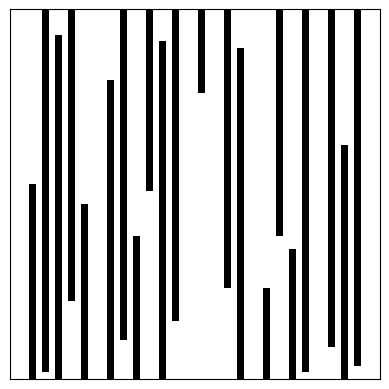

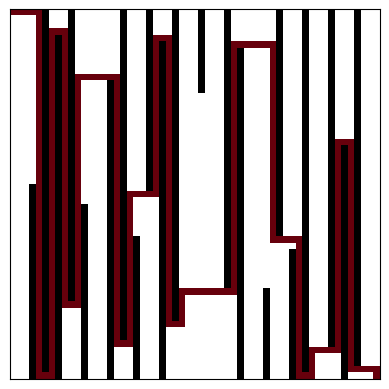

In [412]:
res = generate_maze(57, pattern='slalom', p=0.7)
show_maze(res)
incidence = get_incindence(res)
d = dijkstra(incidence)
path = get_path_dijkstra(d)
show_maze(res, path)

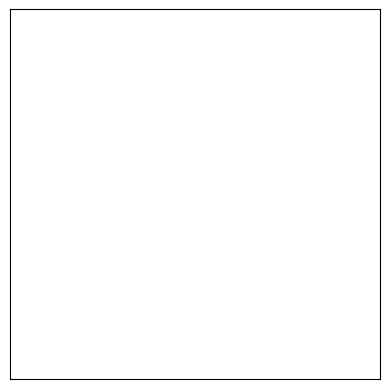

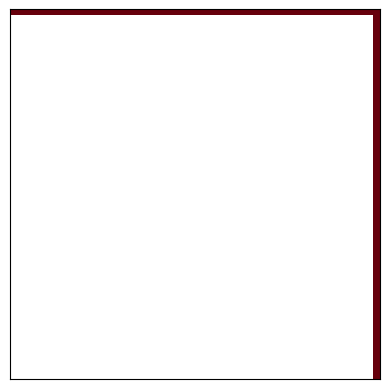

In [413]:
res = generate_maze(57, pattern='empty')
show_maze(res)
incidence = get_incindence(res)
d = dijkstra(incidence)
path = get_path_dijkstra(d)
show_maze(res, path)